## Synthetic data
First lets see what regret looks like for each of the meta experts, (should be sublinear)
Generate synth data, Anh with ridge meta experts, then check each experts loss

In [1]:
import os
os.chdir('..')
from bilevel.synth_datagen import SynthGenLinear
!pwd

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
params = {'samples': 10000, 'dim':20, 
        'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
        'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False, 
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[0 7 1 2 3 4 6 5] ['male' 'native-am' 'female' 'white' 'black' 'two-or-more' 'asian'
 'some-other']


In [71]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more',
       'g_some-other', 'g_asian', 'g_native-am', 'y_male', 'y_female',
       'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian',
       'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active',
       'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_male', 'y_female', 'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian', 'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more', 'g_some-other', 'g_asian', 'g_native-am']


In [5]:
df[filter_feature+filter_label+filter_group].describe()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_max_active,y_dperm_active,g_male,g_female,g_white,g_black,g_two-or-more,g_some-other,g_asian,g_native-am
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,1.000000e+05,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500258,0.500081,0.498519,0.500420,0.499544,5.005351e-01,0.499531,0.499883,4.996934e-01,0.502132,...,0.485005,0.464078,0.49853,0.50147,0.610500,0.118560,0.099780,0.080680,0.059890,0.030590
std,0.288800,0.288651,0.288626,0.288108,0.289142,2.885914e-01,0.287922,0.289000,2.882033e-01,0.288932,...,0.123678,0.134305,0.50000,0.50000,0.487639,0.323272,0.299708,0.272344,0.237284,0.172205
min,0.000004,0.000005,0.000010,0.000018,0.000002,6.558151e-07,0.000005,0.000011,2.066689e-07,0.000002,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249584,0.249287,0.249123,0.251380,0.248657,2.514104e-01,0.251044,0.249041,2.501198e-01,0.252088,...,0.399135,0.369679,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.502561,0.501022,0.497669,0.499929,0.499643,5.007000e-01,0.499082,0.500630,4.999569e-01,0.502238,...,0.482440,0.460299,0.00000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.749627,0.749668,0.747934,0.750141,0.749542,7.502103e-01,0.747923,0.750734,7.487310e-01,0.752877,...,0.567947,0.555725,1.00000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.999993,0.999975,0.999991,0.999991,0.999992,9.999967e-01,0.999993,0.999998,9.999974e-01,0.999996,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.build_all_models import *

In [ ]:
# TODO, ensure everywhere its min max scaled

In [72]:
def get_all_aggregations_linear(df, filter_x, l2_pen = 0.0):
    # y_lab_list = ['y_dperm_active', 'y_mean_active', 'y_min_active', 'y_max_active']
    y_lab_list = ['y_min_active']
    X_dat = df[filter_x]
    # X_dat = numeric_scaler(X_dat, X_dat.columns), synth df already has each feature and label in [0, 1]
    A_t = syn_ob.A_t
    baseline_dict = dict.fromkeys(y_lab_list)
    Anh_dict = dict.fromkeys(y_lab_list)
    for y_lab in y_lab_list:
        y_dat = df[y_lab]
        # y_dat = df[[y_lab]]
        # y_dat = numeric_scaler(y_dat, y_dat.columns)
        # y_dat = y_dat[y_lab]
        dirname_baseline = './synthetic_res_models/baseline'
        filename = 'aggregated_0-1x_w0-1' + y_lab
        baseline_dict[y_lab] = build_baseline_alwayson(dirname_baseline, filename, A_t, OnlineLinearExpert(X_dat, y_dat, l2_pen = l2_pen))
        dirname_Anh = './synthetic_res_models/Anh/'
        Anh_dict[y_lab] = build_Anh(dirname_Anh, filename, A_t, [OnlineLinearExpert(X_dat, y_dat, l2_pen = l2_pen) for _ in range(A_t.shape[1])])
    return baseline_dict, Anh_dict

def barplot_aggregations(baseline_dict, Anh_dict):
    A_t = syn_ob.A_t
    for y_lab in baseline_dict.keys():
       base_ends = [baseline_dict[y_lab].expert.cumloss_groupwise[g][-1] for g in range(A_t.shape[1])]
       Anh_ends = [Anh_dict[y_lab].Anh.cumloss_groupwise_ada[g][-1] for g in range(A_t.shape[1])]
       ind = np.arange(1, A_t.shape[1]+1)
       plt.bar(ind,  base_ends)
       plt.bar(ind, Anh_ends)
       plt.title(y_lab)
       plt.show()

def baseline_vs_Anh_printagg(baseline_dict, Anh_dict):
    A_t = syn_ob.A_t
    for y_lab in baseline_dict.keys():
       active_rounds = [len(baseline_dict[y_lab].expert.cumloss_groupwise[g]) for g in range(A_t.shape[1])]
       base_ends = [baseline_dict[y_lab].expert.cumloss_groupwise[g][-1] for g in range(A_t.shape[1])]
       Anh_ends = [Anh_dict[y_lab].Anh.cumloss_groupwise_ada[g][-1] for g in range(A_t.shape[1])]
       print(y_lab)
       print("Active", active_rounds)
       print("Base:", base_ends)
       print("Anh:", Anh_ends)
       print("---------------")

In [73]:
# try with Ridge experts l2_pen = 1
baseline_dict_ridge, Anh_dict_ridge = get_all_aggregations_linear(df, filter_feature+filter_group, l2_pen = 1.0)


100%|██████████| 10000/10000 [00:23<00:00, 434.27it/s]


y_min_active
Active [4948, 5052, 6086, 1203, 1012, 802, 609, 288]
Base: [80.52171848531943, 77.39886270065116, 93.30523947098379, 24.168366300063422, 17.817074294452905, 9.150342192358615, 9.301325566674427, 4.17823336143766]
Anh: [62.03473888664898, 59.91472752154325, 82.6101859516453, 11.846636418280015, 9.362419158165416, 7.656271404197618, 7.220636410833734, 3.2533170650702816]
---------------


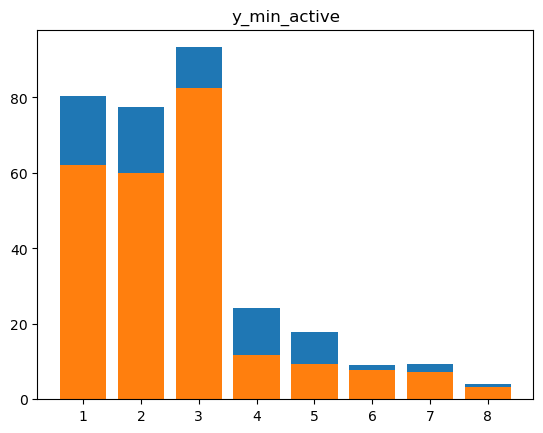

In [75]:
baseline_vs_Anh_printagg(baseline_dict_ridge, Anh_dict_ridge)
barplot_aggregations(baseline_dict_ridge, Anh_dict_ridge)

100%|██████████| 100000/100000 [00:54<00:00, 1825.12it/s]


y_min_active
Active [49847, 50153, 60847, 12061, 9974, 8029, 6050, 3039]
Base: [131.98905136536314, 118.19898280265008, 134.39331782950316, 23.75551264307129, 39.883987635341114, 25.848611233366828, 20.50074203847821, 5.805862788251185]
Anh: [72.72950482442474, 66.5650101842205, 86.48325435992268, 16.53671062514419, 13.232988211496643, 9.366649138232951, 8.070562312349015, 5.60435036149935]
---------------


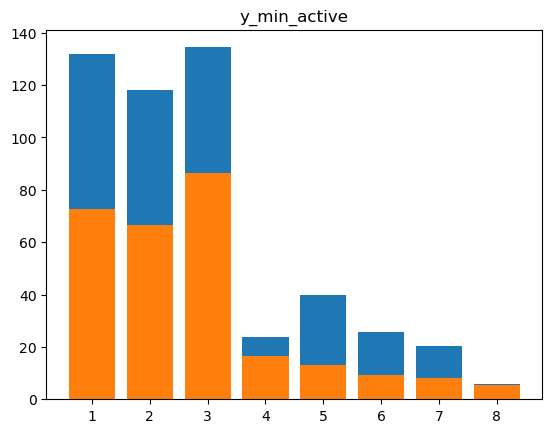

In [13]:
# try with LS, l2 pen = 0 
baseline_dict_ls, Anh_dict_ls = get_all_aggregations_linear(df, filter_feature+filter_group, l2_pen = 0.0)
baseline_vs_Anh_printagg(baseline_dict_ls, Anh_dict_ls)
barplot_aggregations(baseline_dict_ls, Anh_dict_ls)

### Regret asymptotics
 1. check if ```Anh groupwise - its ridge meta group experts loss``` is like $\sqrt{T_g}$ Yes!
 2. ``ridge meta group expert - best in hindsights`` < $||\theta||^2 + \log{(T_g+1)}$ 

### 1 Anh - its ridge meta experts loss

In [11]:
def Anh_minus_groupexpert_plot(Anh):
    N = Anh.A_t.shape[1]
    cumloss_groupwise_ada = Anh.cumloss_groupwise_ada
    cumloss_groupwise_metaexp = Anh.cumloss_groupwise_metaexp
    for gnum in range(N):
        Tg = cumloss_groupwise_ada[gnum].shape[0]
        print(f'''Number of rounds {Tg}, ada shape {cumloss_groupwise_ada[gnum].shape}, meta exp shape {cumloss_groupwise_metaexp[gnum].shape}''')
        diff_at_eacht = cumloss_groupwise_ada[gnum] - cumloss_groupwise_metaexp[gnum]
        plt.plot(np.arange(Tg), diff_at_eacht)
        plt.show()

Number of rounds 49853, ada shape (49853,), meta exp shape (49853,)


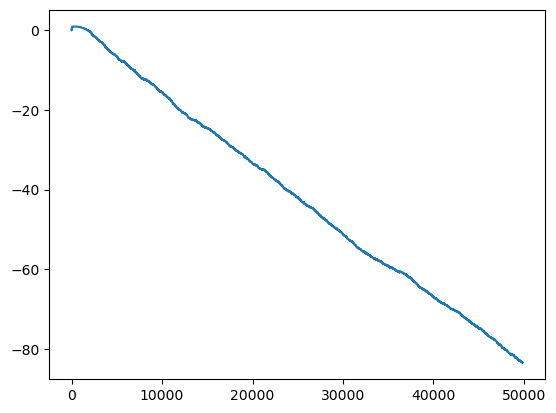

Number of rounds 50147, ada shape (50147,), meta exp shape (50147,)


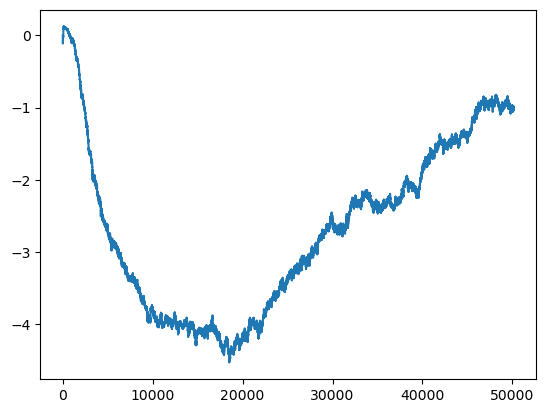

Number of rounds 61050, ada shape (61050,), meta exp shape (61050,)


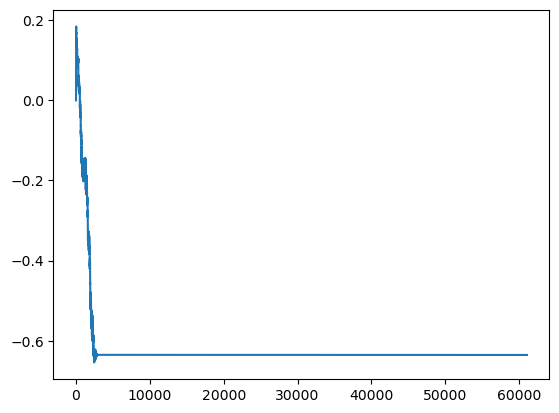

Number of rounds 11856, ada shape (11856,), meta exp shape (11856,)


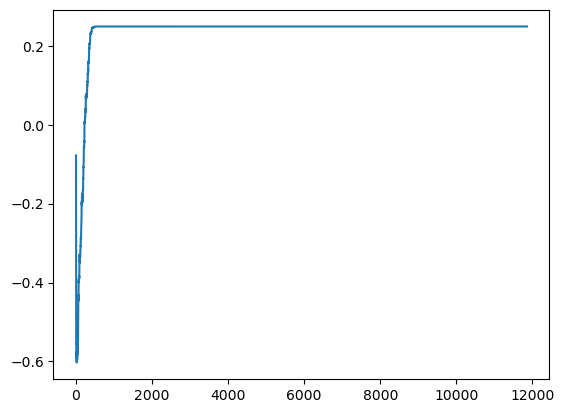

Number of rounds 9978, ada shape (9978,), meta exp shape (9978,)


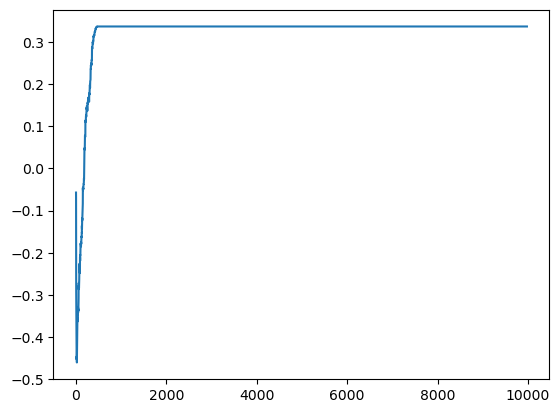

Number of rounds 8068, ada shape (8068,), meta exp shape (8068,)


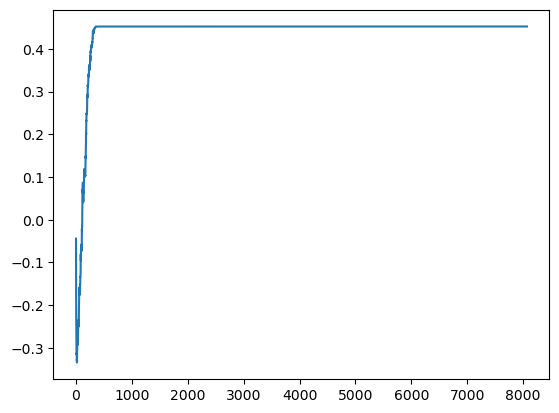

Number of rounds 5989, ada shape (5989,), meta exp shape (5989,)


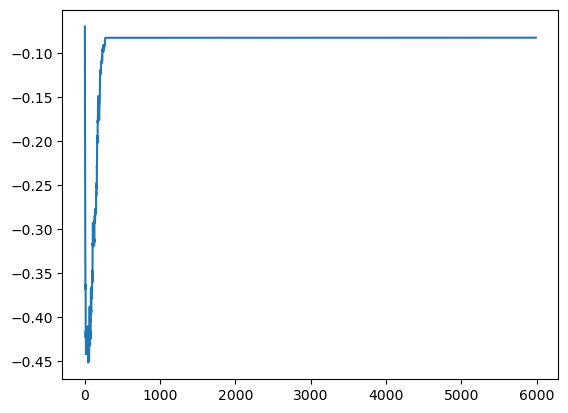

Number of rounds 3059, ada shape (3059,), meta exp shape (3059,)


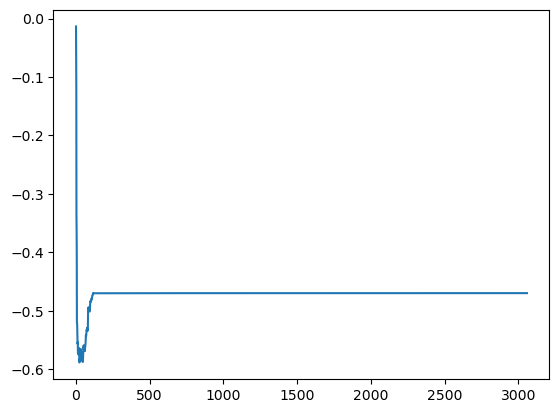

In [12]:
Anh_minus_groupexpert_plot(Anh_dict_ridge['y_min_active'].Anh)

### 2. ridge meta expert - best in hindsight loss

In [30]:
# from sklearn.linear_model import LinearRegression, Ridge

# def plot_Anh_minus_besthindsight(cl_ada_g: np.array, cl_metaexp_g: np.array, X_dat_g, y_dat_g, num_points = 10):
#     '''
#         cl_ada_g: array of shape (Tg,) having the cumulative loss of Anh on this group subsequence
#         cl_metaexp_g: array of shape (Tg,) having the cumulative loss of this group meta expert
#         X_dat_g: rows of the original dataframe where only group g is active
#     '''
#     Tg = len(X_dat_g)
#     print(Tg, cl_ada_g.shape, cl_metaexp_g.shape)
#     sse = [] # sum of squared errors for the best in hindsight, saved in this
#     thetasq = [] # thetanorm squared
#     pos = np.linspace(Tg // num_points, Tg-1, dtype = int, num = num_points) # positions in the dataframe to find best in hindsight 
#     for p in pos:
#         X_batch = X_dat_g[:p]
#         y_batch = y_dat_g[:p]
#         # lr = LinearRegression()
#         # lr.fit(X_batch, y_batch)
#         # sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))
#         # thetasq.append(np.linalg.norm(lr.coef_)**2)
#         ridge = Ridge()
#         ridge.fit(X_batch, y_batch)
#         sse.append(np.sum((ridge.predict(X_batch) - y_batch)**2))
#         thetasq.append(np.linalg.norm(ridge.coef_)**2)
#     sse = np.array(sse)
#     thetasq = np.array(thetasq)
#     # print(f"pos : {pos}")
#     # print(f"cl ada: {cl_ada_g[pos]}")
#     # print(f"cl meta exp: {cl_metaexp_g[pos]}")
#     # print(f"sse {sse}")
#     # print(f"thetasq  {thetasq}")
#     # print(f"Anh group - best hindsight loss {(cl_ada_g[pos] - sse)}")
#     # print(f"group meta exp - best hindsight loss {(cl_metaexp_g[pos] - sse)}")
#     # print(pos, cl_metaexp_g[pos] - sse -thetasq)
#     plt.plot(pos, cl_ada_g[pos] - sse - thetasq, label = 'ada group regret')
    
#     plt.plot(np.arange(Tg), np.arange(Tg)**0.5)
#     # plt.plot(pos, cl_metaexp_g[pos] - sse - thetasq, label = 'meta exp regret')
#     # plt.plot(pos, pos**0.5, label = 'sqrt pos')
#     plt.legend()
#     plt.show()

#     plt.plot(pos, thetasq, label = 'theta_norm_sq')
#     plt.legend()
#     plt.show()
#     # plt.plot(pos, cl_ada_g[pos] - sse, label = 'ada group regret')
#     # plt.plot(pos, cl_metaexp_g[pos] - sse, label = 'meta exp regret')
#     # plt.plot(pos, pos**0.5, label = 'sqrt pos')
#     # plt.legend()
#     # plt.show()


In [17]:
from sklearn.linear_model import LinearRegression
X_dat_g = df[df['g_male'] == 1][filter_feature + filter_group]
y_dat_g = df[df['g_male'] == 1]['y_min_active']
lr = LinearRegression()
lr.fit(X_dat_g, y_dat_g)
lr.score(X_dat_g, y_dat_g)

0.9029113646389644

g_male 4948


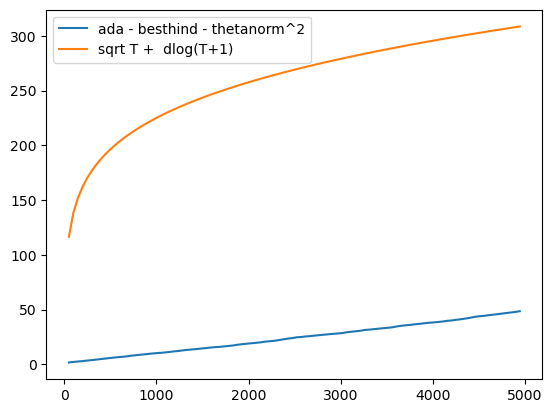

g_female 5052


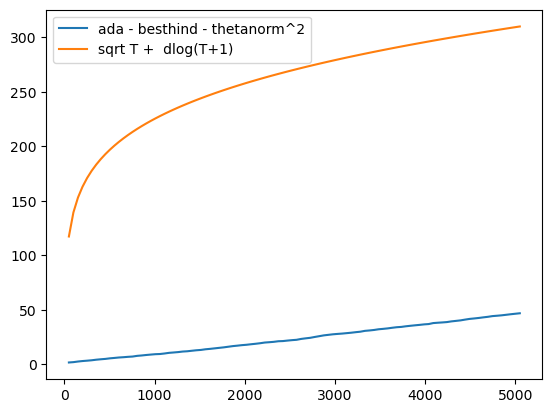

g_white 6086


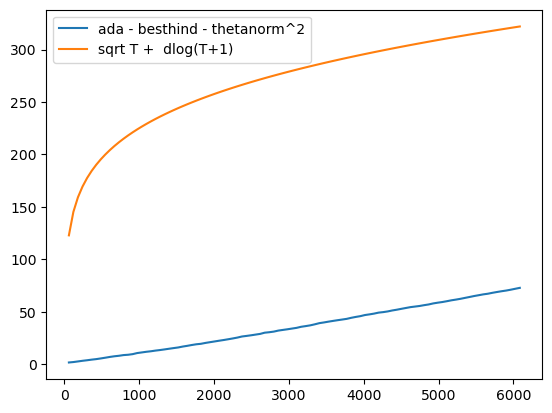

g_black 1203


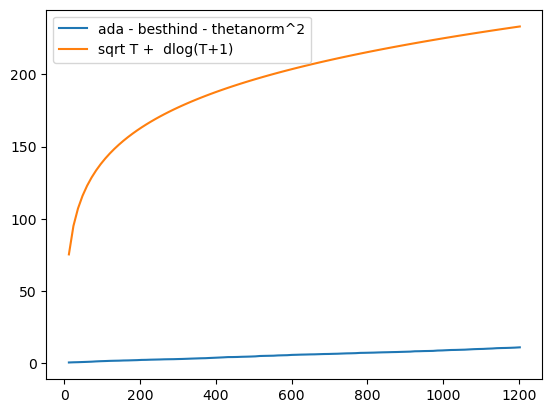

g_two-or-more 1012


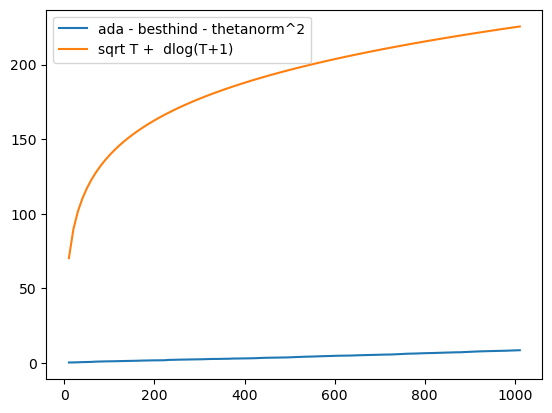

g_some-other 802


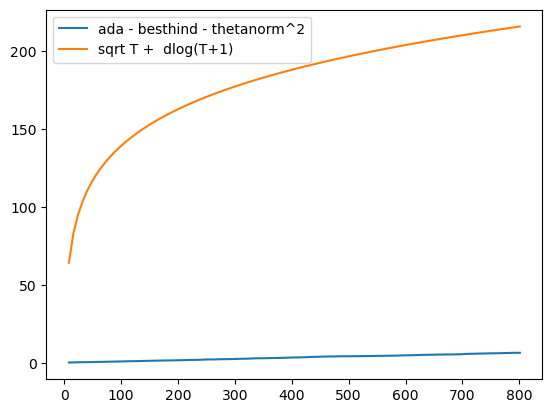

g_asian 609


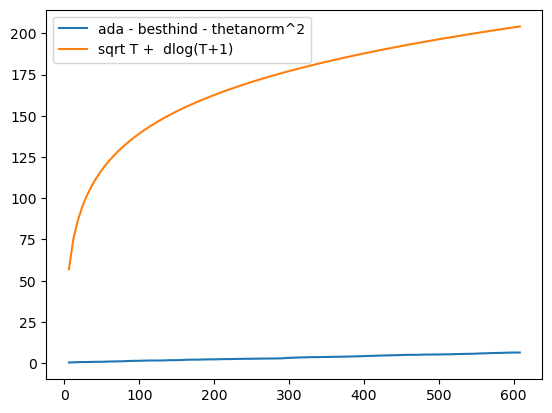

g_native-am 288


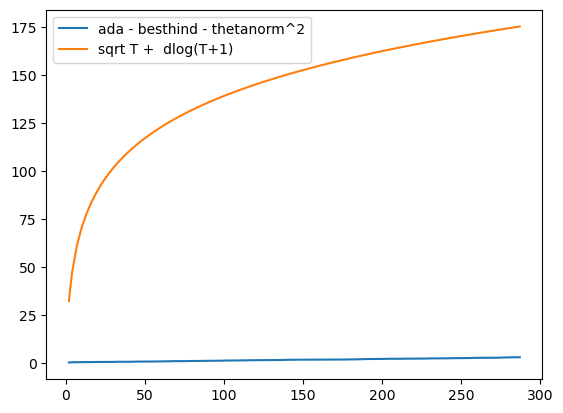

In [76]:
# cl_group_metaexp = Anhrm.cumloss_groupwise_metaexp TODO
Anh_synth = Anh_dict_ridge['y_min_active'].Anh
for g_ind, gname in enumerate(filter_group):
    X_dat_g = df[df[gname] == 1][filter_feature + filter_group]
    y_dat_g = df[df[gname] == 1]['y_min_active']
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh_synth.cumloss_groupwise_ada[g_ind], Anh_synth.cumloss_groupwise_metaexp[g_ind], 
    X_dat_g, y_dat_g, num_points = min(100, Tg))

### 3 Sanity check that Anh - best in hindsight = Anh - group meta exp + (group meta exp - best in hindisght)

In [46]:
# def find_besthindsight(cl_metaexp_gname, X_dat_g, y_dat_g, num_points = 10):
#     Tg = len(X_dat_g)
#     sse = []
#     thetasq = []
#     # print(Tg)
#     # print(Tg // num_points)
#     pos = np.linspace(100, Tg-1, dtype = int, num = num_points)
#     # print(len(pos))
#     for p in pos:
#         X_batch = X_dat_g[:p]
#         y_batch = y_dat_g[:p]
#         # print(X_dat_g.shape, y_batch.shape)
#         lr = LinearRegression()
#         lr.fit(X_batch, y_batch)
#         sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))
#         thetasq.append(np.linalg.norm(lr.coef_)**2)
#     sse = np.array(sse)
#     thetasq = np.array(thetasq)
#     # print(f"pos : {pos}")
#     print(f"cl meta exp: {cl_metaexp_gname[pos]}")
#     print(f"sse {sse}")
#     print(f"thetasq  {thetasq}")
#     print(f"meta exp - best hindsight loss {(cl_metaexp_gname[pos] - sse)}")
#     plt.axis('scaled')
#     plt.plot(pos, cl_metaexp_gname[pos] - sse)
#     plt.show()

## Insurance premium/charge dataset

In [14]:
from bilevel.utils import *
from bilevel.Adahedge_vectorized import *
from bilevel.OnlineLinearExpert import *
from bilevel.build_all_models import *

In [5]:
df_medical = pd.read_csv('./data_small/insurance.csv')
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# 4 groups like in the overleaf
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight 
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])

A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1
A_t_medical_groups.sum(axis=0)

young             574
middle            408
old               356
underweight        20
healthyweight     225
overweight        386
obese             707
smoker            274
non-smoker       1064
male              676
female            662
always_on        1338
dtype: int64

In [88]:
# code for plotting the regret curves
from sklearn.linear_model import LinearRegression, Ridge

def plot_Anh_minus_besthindsight(cl_ada_g: np.array, cl_metaexp_g: np.array, X_dat_g, y_dat_g, num_points = 10):
    '''
        cl_ada_g: array of shape (Tg,) having the cumulative loss of Anh on this group subsequence
        cl_metaexp_g: array of shape (Tg,) having the cumulative loss of this group meta expert
        X_dat_g: rows of the original dataframe where only group g is active
    '''
    Tg, d = X_dat_g.shape
    sse = [] # sum of squared errors for the best in hindsight, saved in this
    thetasq = [] # thetanorm squared
    pos = np.linspace(Tg // num_points, Tg-1, dtype = int, num = num_points) # positions in the dataframe to find best in hindsight 
    for p in pos:
        X_batch = X_dat_g[:p]
        y_batch = y_dat_g[:p]
        # ridge = Ridge()
        # ridge.fit(X_batch, y_batch)
        # sse.append(np.sum((ridge.predict(X_batch) - y_batch)**2))
        # thetasq.append(np.linalg.norm(ridge.coef_)**2)
        
        lr = LinearRegression()
        lr.fit(X_batch, y_batch)
        sse.append(np.sum((lr.predict(X_batch) - y_batch)**2))
        # thetasq.append(np.linalg.norm(lr.coef_)**2)


    sse = np.array(sse)
    # thetasq = np.array(thetasq)
    # plt.plot(pos, cl_ada_g[pos] - sse - thetasq, label = 'ada - ridge_hind - theta_ridgenorm^2') # TODO only for ridge is theta norm well behaved
    plt.plot(pos, cl_ada_g[pos] - sse, label = 'ada - besthind_ls')
    # plt.plot(pos,pos**0.5 +  d * np.log(1 + pos), label = 'sqrt T +  dlog(T+1)')
    plt.legend()
    plt.show()


In [15]:
A_t_med_shuf = A_t_medical_groups.to_numpy()
X_dat = df_medical_mm_oh.drop('charges', axis=1)
y_dat = df_medical_mm_oh['charges']

dirname = './models_adult/baseline/'
filename = 'ridge_medical_regretinvestigation'

expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_med_shuf, expridge)
dirname = './models_adult/Anh/'
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_med_shuf.shape[1])]
b_Anh = build_Anh(dirname, filename, A_t_med_shuf, experts)

100%|██████████| 1338/1338 [00:13<00:00, 100.87it/s]


young 574


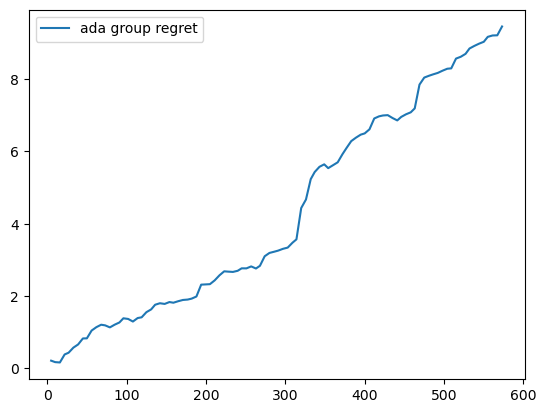

middle 408


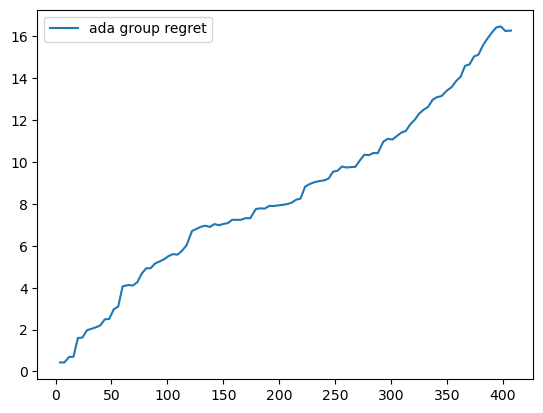

old 356


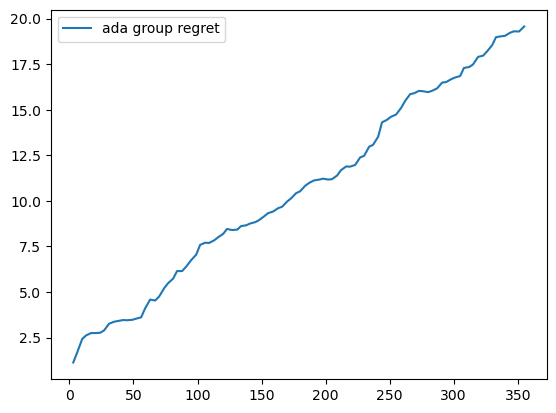

underweight 20


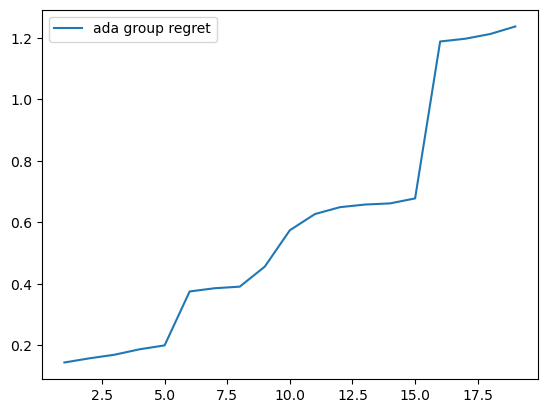

healthyweight 225


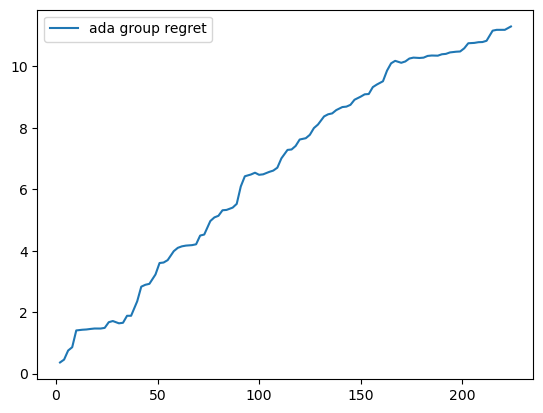

overweight 386


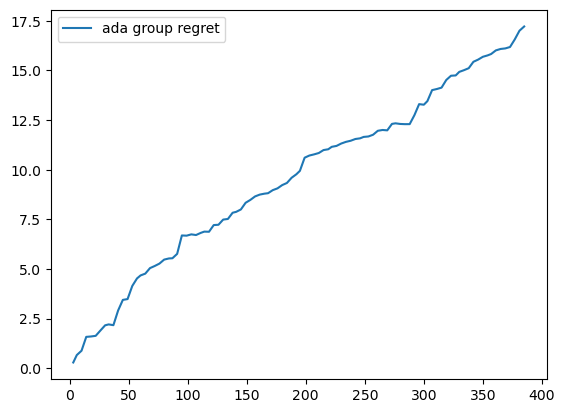

obese 707


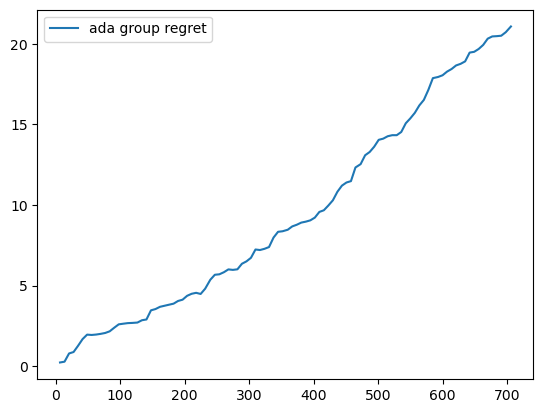

smoker 274


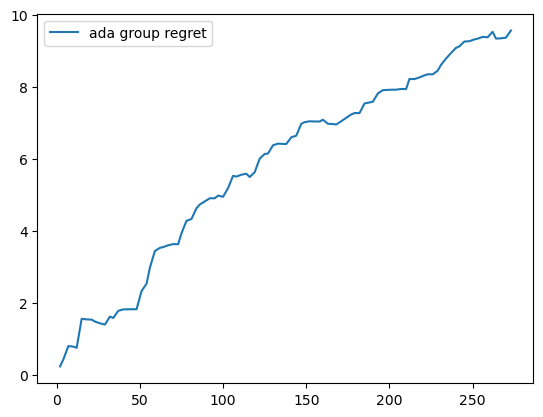

non-smoker 1064


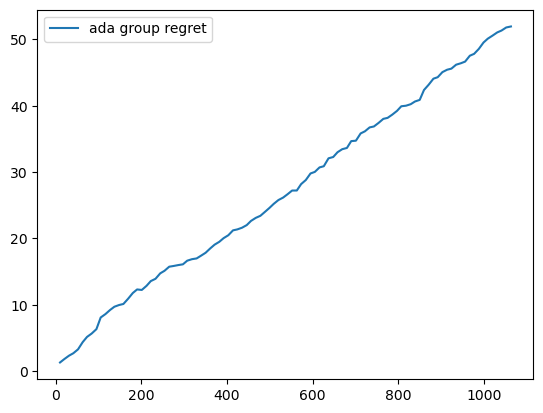

male 676


IndexError: index 472 is out of bounds for axis 0 with size 471

In [47]:
Anh = b_Anh.Anh
for g_ind, gname in enumerate(A_t_medical_groups.columns):
    indices_g = (A_t_medical_groups[gname] == 1)
    X_dat_g = df_medical_mm_oh[indices_g].drop('charges', axis=1)
    y_dat_g = df_medical_mm_oh[indices_g]['charges']
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

## Adult income dataset

In [18]:
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')
print(df_adult.shape)

numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh.head()

(49531, 14)


,hours-per-week,age,capital-gain,capital-loss,education-num,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.193878,0.315068,0.0,0.0,0.800000,0.490460,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.397959,0.054795,0.0,0.0,0.600000,0.114053,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.091837,0.000000,0.0,0.0,0.400000,0.024957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.500000,0.465753,0.0,0.0,0.533333,0.389320,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.377551,0.150685,0.0,0.0,0.800000,0.413376,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [19]:
df_adult['age'].describe()

count    49531.000000
mean        38.554320
std         13.701025
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [27]:
df_adult[df_adult['age'] <= 35]['income'].mean(),  \
df_adult[(df_adult['age'] > 35) & (df_adult['age'] <= 50)]['income'].mean(), \
df_adult[df_adult['age'] > 50]['income'].mean()

(23188.593804843804, 43645.154374740836, 40017.01754919862)

In [37]:
# 4 groups like in the overleaf
A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool_orless', 'College_ormore'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])

A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups.sum(axis=0)

young                 22792
middle                16881
old                    9858
HighSchool_orless     22584
College_ormore        26947
Male                  33174
Female                16357
White                 42441
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      471
Other                   406
Black                  4694
always_on             49531
dtype: int64

In [82]:
A_t_adult_np = A_t_adult_groups.to_numpy()
X_dat = df_adult_mm_oh.drop('income', axis=1)
y_dat = df_adult_mm_oh['income']

dirname = './models_adult/baseline/'
filename = 'ridge_adult_regretinvestigation'

# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0)
# b_ridgebase = build_baseline_alwayson(dirname, filename, A_t_adult_np, expridge)
dirname = './models_adult/Anh/'
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 1.0) for _ in range(A_t_adult_np.shape[1])]
b_Anh_ridge = build_Anh(dirname, filename, A_t_adult_np, experts)

100%|██████████| 49531/49531 [09:25<00:00, 87.63it/s] 


young 22792


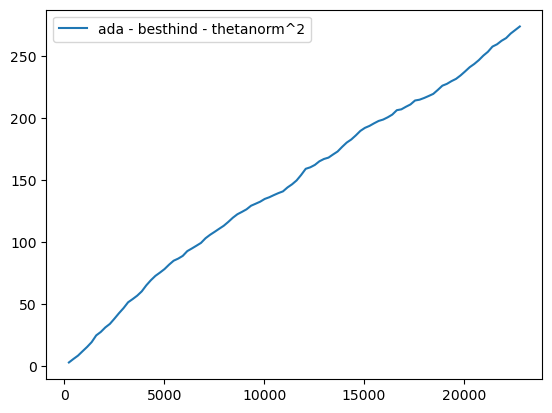

middle 16881


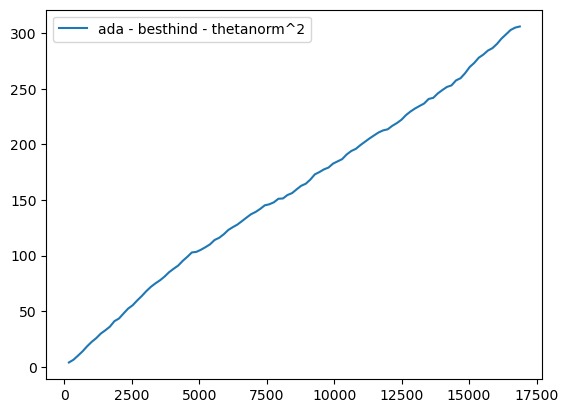

old 9858


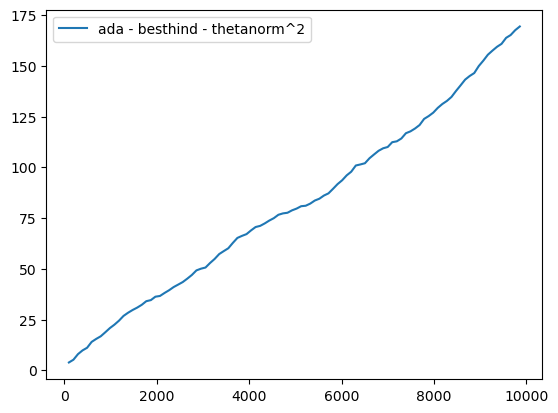

HighSchool_orless 22584


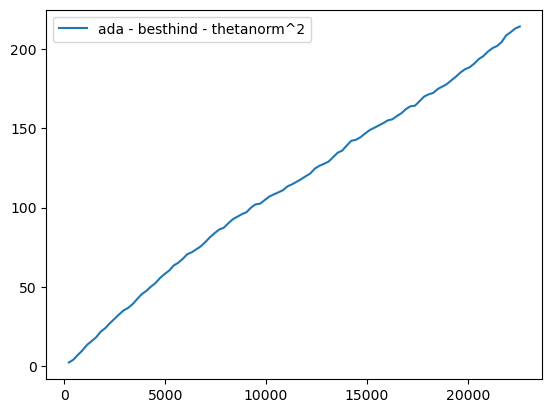

College_ormore 26947


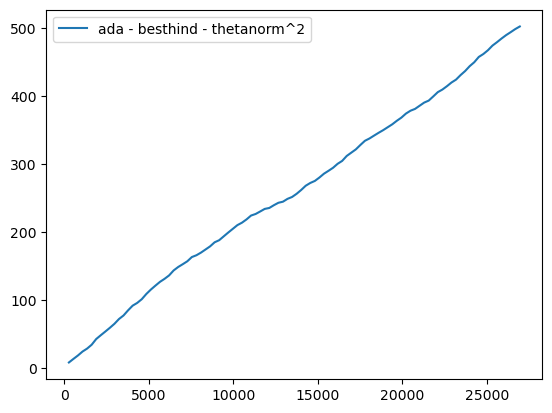

Male 33174


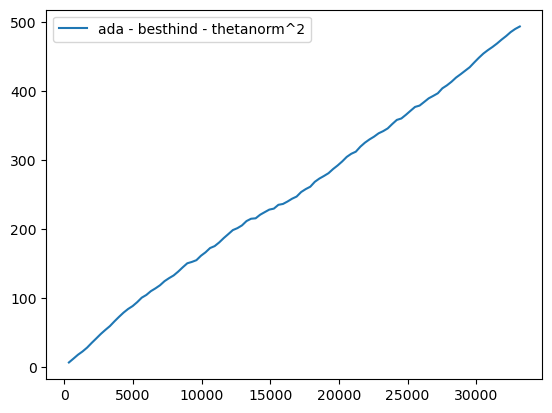

Female 16357


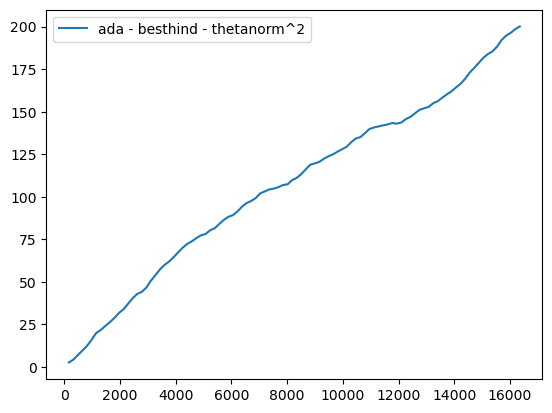

White 42441


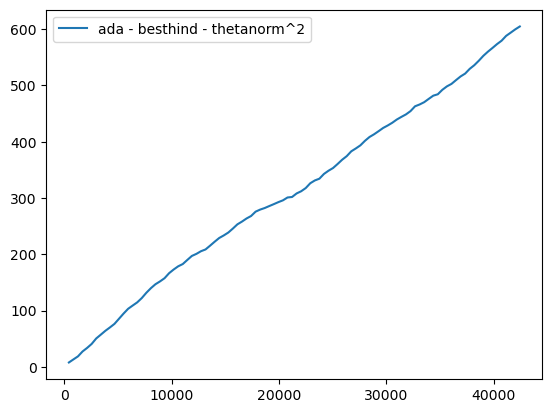

Asian-Pac-Islander 1519


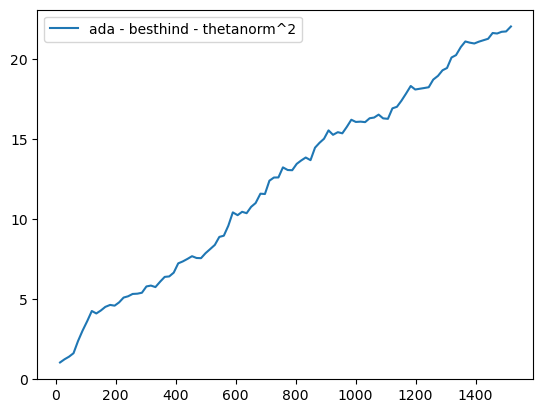

Amer-Indian-Eskimo 471


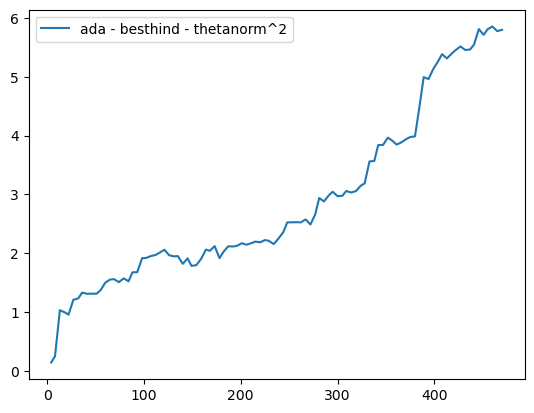

Other 406


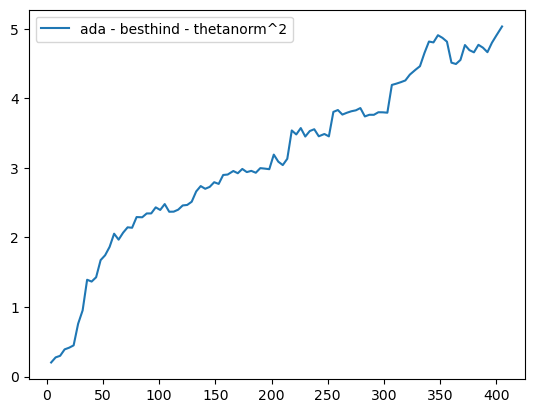

Black 4694


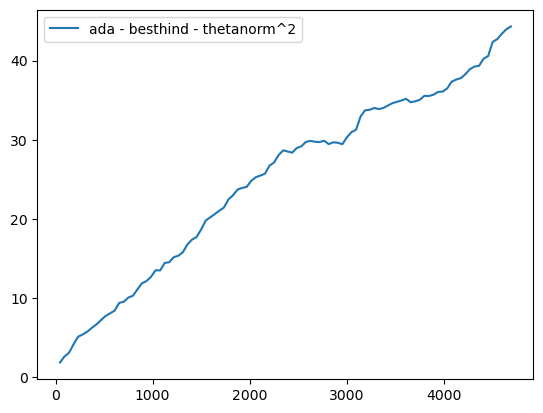

always_on 49531


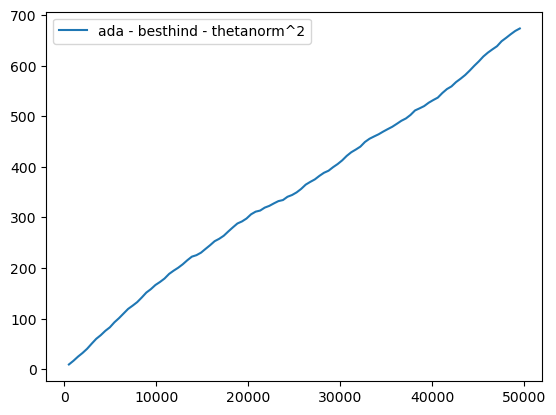

In [83]:
Anh = b_Anh_ridge.Anh
for g_ind, gname in enumerate(A_t_adult_groups.columns):
    indices_g = (A_t_adult_groups[gname] == 1)
    X_dat_g = X_dat[indices_g]
    y_dat_g = y_dat[indices_g]
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

In [77]:
A_t_adult_np = A_t_adult_groups.to_numpy()
X_dat = df_adult_mm_oh.drop('income', axis=1)
y_dat = df_adult_mm_oh['income']

dirname = './models_adult/baseline/'
filename = 'ls_adult_regretinvestigation'

# expridge = OnlineLinearExpert(X_dat, y_dat, l2_pen = 0)
# b_ls = build_baseline_alwayson(dirname, filename, A_t_adult_np, expridge)
dirname = './models_adult/Anh/'
experts = [OnlineLinearExpert(X_dat, y_dat, l2_pen = 0) for _ in range(A_t_adult_np.shape[1])]
b_Anh_ls = build_Anh(dirname, filename, A_t_adult_np, experts)

100%|██████████| 49531/49531 [07:23<00:00, 111.56it/s]


young 22792


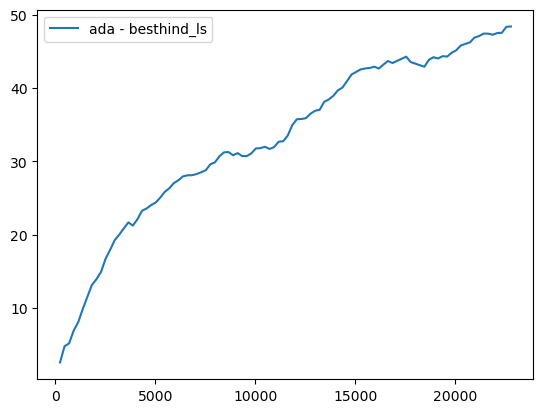

middle 16881


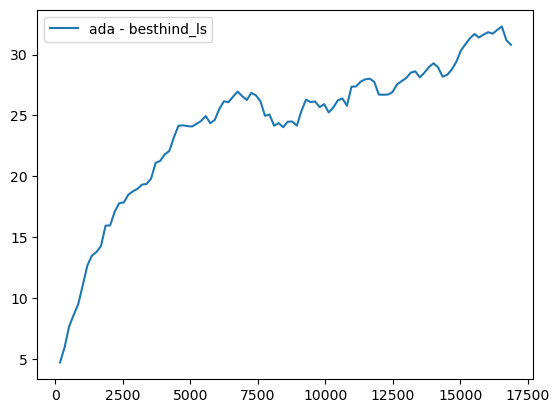

old 9858


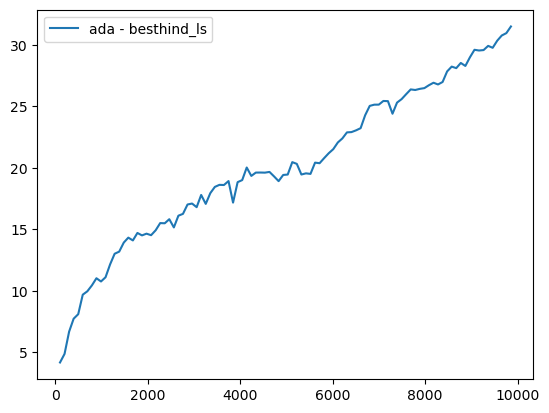

HighSchool_orless 22584


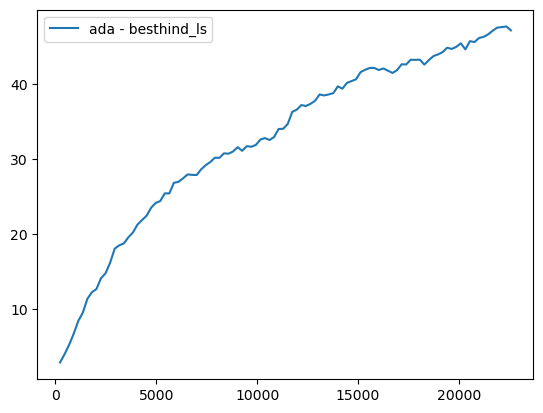

College_ormore 26947


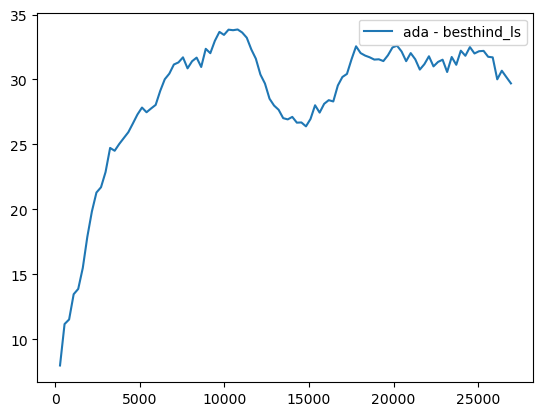

Male 33174


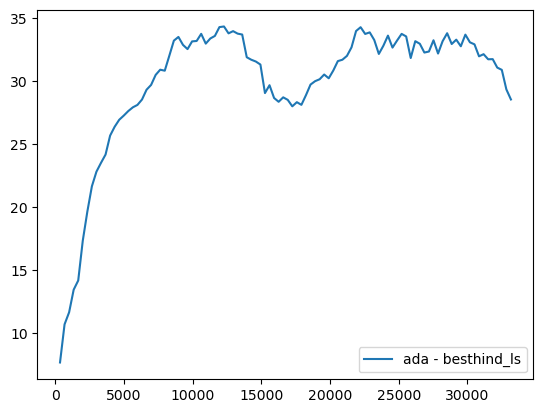

Female 16357


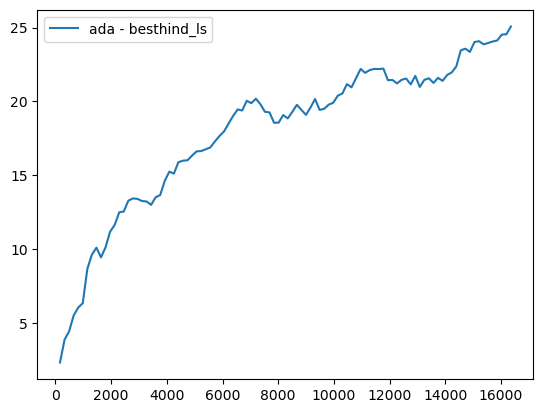

White 42441


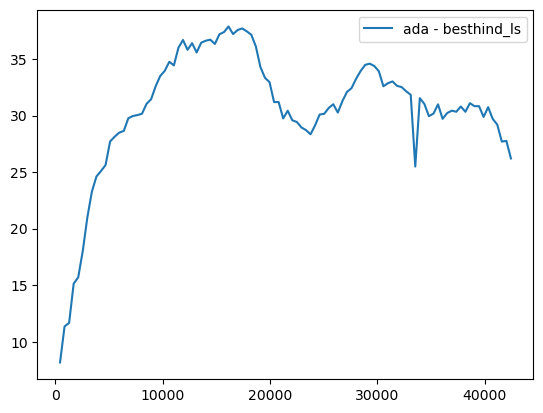

Asian-Pac-Islander 1519


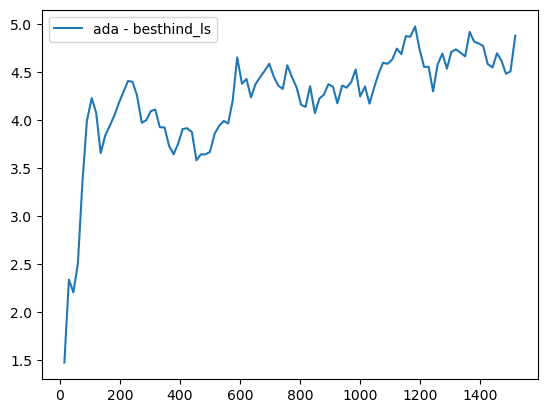

Amer-Indian-Eskimo 471


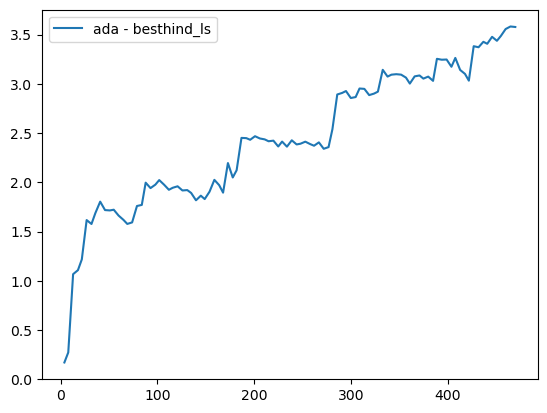

Other 406


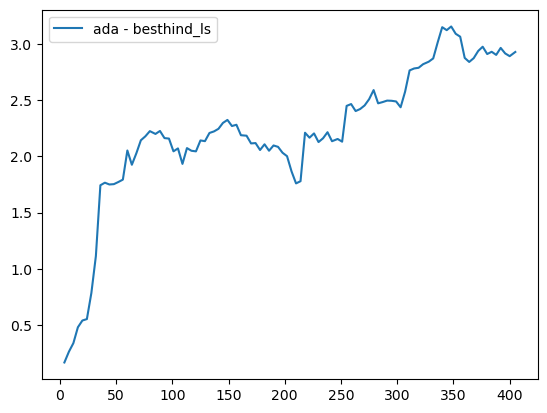

Black 4694


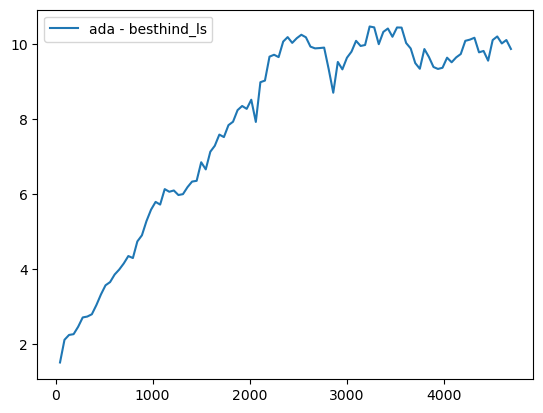

always_on 49531


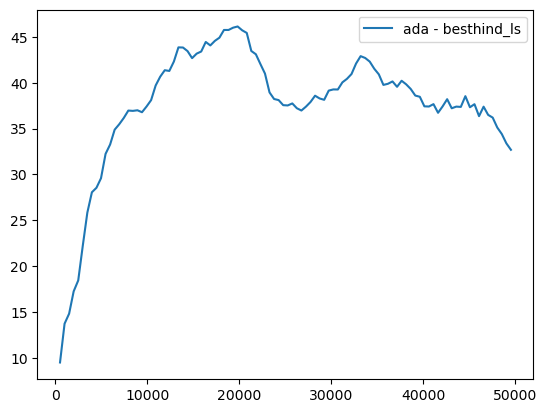

In [89]:
Anh = b_Anh_ls.Anh
for g_ind, gname in enumerate(A_t_adult_groups.columns):
    indices_g = (A_t_adult_groups[gname] == 1)
    X_dat_g = X_dat[indices_g]
    y_dat_g = y_dat[indices_g]
    Tg = X_dat_g.shape[0]
    print(gname, Tg)
    plot_Anh_minus_besthindsight(Anh.cumloss_groupwise_ada[g_ind],
                                 Anh.cumloss_groupwise_metaexp[g_ind], X_dat_g, y_dat_g, 
                                 num_points = min(100, Tg))

In [ ]:
# batch 